In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from random import normalvariate
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy import fftpack,signal
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.special import jv
from scipy import interpolate, integrate
from scipy.integrate import complex_ode,simpson
from scipy import special
from arc import *
from scipy.optimize import curve_fit
from sympy.physics.wigner import wigner_3j ,wigner_6j
#from maxwellbloch import mb_solve, field, ob_atom
import matplotlib as mpl
from scipy.integrate import quad


In [ ]:
# 计算 ML Wannier 函数的质心位置
def Ham(m,kx,ky,kz,t):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])

    gamma0 = np.kron(sigmaz,np.eye(2))
    gamma1 = np.kron(sigmay,sigmay)
    gamma2 = np.kron(sigmay,sigmax)
    gamma3 = np.kron(sigmay,sigmaz)
    gamma4 = np.kron(sigmax,np.eye(2))

    h0 = m+ np.cos(kx)+np.cos(ky)+np.cos(kz) + np.cos(t)
    h1 = np.sin(kx)
    h2 = np.sin(ky)
    h3 = np.sin(kz)
    h4 = np.sin(t)
    H = h0*gamma0 + h1*gamma1 + h2*gamma2 + h3*gamma3 + h4*gamma4
    return H

def ProjectionSpin(m,kx,ky,kz,kw):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    spinsector = np.kron(np.eye(2),sigmaz)
    H = Ham(m,kx,ky,kz,kw)
    _,eigvec = np.linalg.eigh(H)
    #eigvec1 = eigvec[:,0].reshape(4,1)
    #eigvec2 = eigvec[:,1].reshape(4,1)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(4,1)))[0][0]
    #P = eigvec1@(eigvec1.T.conjugate()) + eigvec2@(eigvec2.T.conjugate())
    return U

def getSpinState(m,kx,ky,kz,kw):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    
    spinsector = np.kron(np.eye(2),sigmay)
    H = Ham(m,kx,ky,kz,kw)
    Eband,eigvec = np.linalg.eigh(H)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(4,1)))[0][0]
    Espin,Vu = np.linalg.eigh(U)
    Vup = Vu[0,1]*eigvec[:,0] + Vu[1,1]*eigvec[:,1]
    Vdown = Vu[0,0]*eigvec[:,0] + Vu[1,0]*eigvec[:,1]
    return Vup, Vdown, Eband, Espin





def Wanniercoeff(m,kx,ky,kz,t):
    kz1 = np.append(kz,np.pi)
    EigenVector = np.zeros((len(kz1),2,4,1),dtype=complex)
    coeff = np.zeros((len(kz),2,2),dtype=complex)
    for i in np.arange(len(kz1)):
        H = Ham(m,kx,ky,kz1[i],t)
        EigenE,EigenV = np.linalg.eigh(H)
        for j in np.arange(2):
            EigenVector[i,j] = EigenV[:,j].reshape(4,1)

    for i in np.arange(len(kz)):
        for m in np.arange(2):
            for n in np.arange(2):
                coeff[i,m,n] = (EigenVector[i+1,m].T.conjugate()@EigenVector[i,n])[0][0]
    return coeff, EigenVector

def getXnn1(m,kx,ky,kz,t,dk,n,n1,N):
    coeff,EigenVector = Wanniercoeff(m,kx,ky,kz,t)    
    nn1 = 1/N*np.exp(1j*n*(kz+dk)-1j*n1*kz)
    Matrix  = np.zeros((4,4),dtype=complex)
    for i in np.arange(len(kz)):
        for bandn in np.arange(2):
            for bandm in np.arange(2):
                Matrix += coeff[i,bandn,bandm]*nn1[i]*(EigenVector[i+1,bandn]@EigenVector[i,bandm].T.conjugate())
    #Matrix += coeff[-1]*mm1[-1]*EigenVector[0]@EigenVector[-1].T.conjugate()
    return Matrix

def getXOperator(m,kx,ky,kz,t,dk,N):
    #m = np.arange(N)
    Hx = np.zeros((N*4,N*4),dtype=complex)
    for i in np.arange(N):
        for j in np.arange(N):
            Hx[i*4:(i+1)*4][:,j*4:(j+1)*4] = getXnn1(m,kx,ky,kz,t,dk,i,j,N)
    return Hx

def Hamreal(m,kx,ky,t,N):
    H = np.zeros((N*4,N*4),dtype=complex)
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])

    gamma0 = np.kron(sigmaz,np.eye(2))
    gamma1 = np.kron(sigmay,sigmay)
    gamma2 = np.kron(sigmay,sigmax)
    gamma3 = np.kron(sigmay,sigmaz)
    gamma4 = np.kron(sigmax,np.eye(2))

    h0 = m + np.cos(kx)+np.cos(ky) + np.cos(t)
    h1 = np.sin(kx)
    h2 = np.sin(ky)
    h4 = np.sin(t)

    Onsite = h0*gamma0 + h1*gamma1 + h2*gamma2 + h4*gamma4
    tun = 1/2*gamma0 - 1j*1/2*gamma3
    tun1 = 1/2*gamma0 + 1j*1/2*gamma3
    for i in np.arange(N):
        for j in np.arange(N):
            if i==j:
                H[i*4:(i+1)*4][:,j*4:(j+1)*4] = Onsite
            if i == j-1:
                H[i*4:(i+1)*4][:,j*4:(j+1)*4] = tun
            if i == j+1:
                H[i*4:(i+1)*4][:,j*4:(j+1)*4] = tun1
    H[0:4][:,4*(N-1):4*N] = tun1
    H[4*(N-1):4*N][:,0:4] = tun
    return H


def CurrentOp(N):
    H = np.zeros((N*4,N*4),dtype=complex)
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])

    gamma0 = np.kron(sigmaz,np.eye(2))
    gamma1 = np.kron(sigmay,sigmay)
    gamma2 = np.kron(sigmay,sigmax)
    gamma3 = np.kron(sigmay,sigmaz)
    gamma4 = np.kron(sigmax,np.eye(2))


    
    tun = 1/2*gamma3 + 1j*1/2*gamma0
    tun1 = 1/2*gamma3 - 1j*1/2*gamma0
    for i in np.arange(N):
        for j in np.arange(N):
            if i == j-1:
                H[i*4:(i+1)*4][:,j*4:(j+1)*4] = tun
            if i == j+1:
                H[i*4:(i+1)*4][:,j*4:(j+1)*4] = tun1
    H[0:4][:,4*(N-1):4*N] = tun1
    H[4*(N-1):4*N][:,0:4] = tun
    return H

def Evlolve(m,kx,ky,N,phi0,T):
    t = np.linspace(0,T,20000)
    phi = np.zeros((len(t),4*N,1),dtype=complex)
    phi[0] = phi0
    kw = 2*np.pi*t/T+np.pi/2
    dt = t[1]-t[0]
    for i in np.arange(len(t)-1):
        H = Hamreal(m,kx,ky,kw[i],N)
        dU = expm(-1j*H*dt)
        phi[i+1] = dU@phi[i]
    return phi

In [6]:
N = 100
kz = np.arange(-np.pi,np.pi,2*np.pi/N)
dk = kz[1]-kz[0]
m = -3
kx = np.pi/10
ky = 0
t = np.pi/2
H = getXOperator(m,kx,ky,kz,t,dk,N)
E,V = np.linalg.eig(H)

In [7]:
indices = np.where(np.abs(E) > 0.1)[0]

d:\anaconda\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\anaconda\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


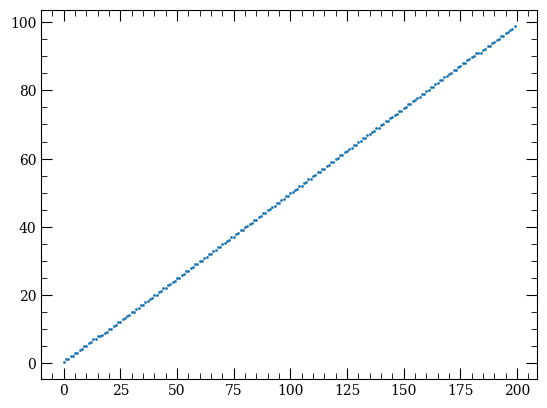

In [8]:
Center = np.zeros(len(indices),dtype=complex)
positon = np.kron(np.diag(np.arange(N)),np.eye(4))
for i in np.arange(len(indices)):
    Center[i] = (((V[:,indices[i]].reshape(len(E),1)).T.conjugate())@positon@V[:,indices[i]].reshape(len(E),1))[0][0]
indexV = np.argsort(Center)
plt.scatter(np.arange(len(Center)),Center[indexV],s=1)

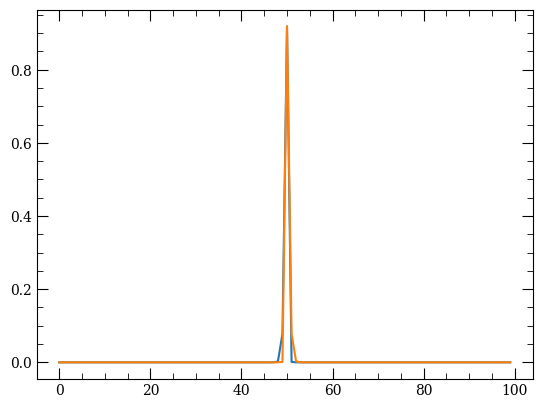

In [9]:
phi0 = (V[:,indices[indexV[100]]]).reshape(4*N,1)
phi01 = (V[:,indices[indexV[101]]]).reshape(4*N,1)
plt.plot(np.arange(N),np.abs(phi0[::4])**2+np.abs(phi0[1::4])**2+np.abs(phi0[3::4])**2+np.abs(phi0[2::4])**2)
plt.plot(np.arange(N),np.abs(phi01[::4])**2+np.abs(phi01[1::4])**2+np.abs(phi01[3::4])**2+np.abs(phi01[2::4])**2)

In [11]:
T= 200
rho = Evlolve(m,kx,ky,N,phi0,T)

In [12]:
rho1 = Evlolve(m,kx,ky,N,phi01,T)

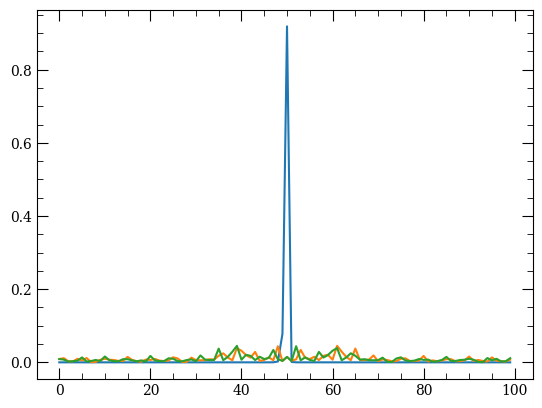

In [13]:
plt.plot(np.arange(N),np.abs(rho[0,::4])**2+np.abs(rho[0,1::4])**2+np.abs(rho[0,3::4])**2+np.abs(rho[0,2::4])**2)
plt.plot(np.arange(N),np.abs(rho[-1,::4])**2+np.abs(rho[-1,1::4])**2+np.abs(rho[-1,3::4])**2+np.abs(rho[-1,2::4])**2)
plt.plot(np.arange(N),np.abs(rho1[-1,::4])**2+np.abs(rho1[-1,1::4])**2+np.abs(rho1[-1,3::4])**2+np.abs(rho1[-1,2::4])**2)

In [14]:
current = CurrentOp(N)
dcom = np.zeros(len(rho),dtype=complex)
dcom1 = np.zeros(len(rho1),dtype=complex)
for i in np.arange(len(rho)):
    dcom[i] = (rho[i].T.conjugate()@current@rho[i])[0][0]
    dcom1[i] = (rho1[i].T.conjugate()@current@rho1[i])[0][0]

In [15]:
COM = np.zeros(len(rho),dtype=complex)
COM1 = np.zeros(len(rho1),dtype=complex)
positon = np.kron(np.diag(np.arange(N)),np.eye(4))
for i in np.arange(len(rho)):
    COM[i] = ((rho[i].T.conjugate())@positon@rho[i])[0][0]
for i in np.arange(len(rho1)):
    COM1[i] = ((rho1[i].T.conjugate())@positon@rho1[i])[0][0]

d:\anaconda\lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-0.3463801914152853-1.734723475976807e-18j)
(0.888992442012505-2.3984864609268063e-17j)
(-0.5527887971336369-4.458239333260394e-16j)
(-0.41631897018929137+4.757310312552317e-17j)


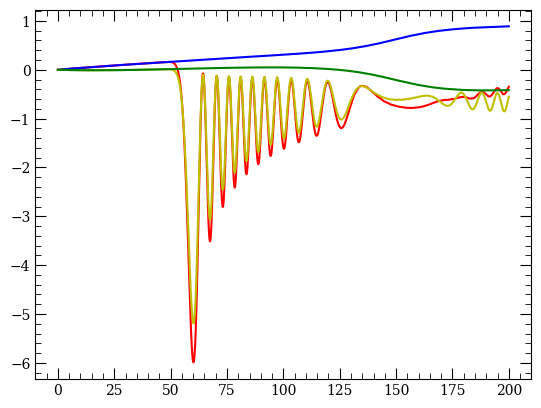

In [16]:
time = np.linspace(0,T,20000)
dt = time[1]-time[0]
plt.plot(np.linspace(0,T,20000),COM-COM[0],c='r')
plt.plot(np.linspace(0,T,20000),np.cumsum(dcom)*dt,c='b')
print(COM[-1]-COM[0])
print((np.cumsum(dcom)*dt)[-1])
plt.plot(np.linspace(0,T,20000),COM1-COM1[0],c='y')
plt.plot(np.linspace(0,T,20000),np.cumsum(dcom1)*dt,c='g')
print(COM1[-1]-COM1[0])
print((np.cumsum(dcom1)*dt)[-1])

In [91]:
def Ham(m,kx,ky,kz,t):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])

    gamma0 = np.kron(sigmaz,np.eye(2))
    gamma1 = np.kron(sigmay,sigmay)
    gamma2 = np.kron(sigmay,sigmax)
    gamma3 = np.kron(sigmay,sigmaz)
    gamma4 = np.kron(sigmax,np.eye(2))

    h0 =m+ np.cos(kx)+np.cos(ky)+np.cos(kz) + np.cos(t)
    h1 = np.sin(kx)
    h2 = np.sin(ky)
    h3 = np.sin(kz)
    h4 = np.sin(t)
    H = h0*gamma0 + h1*gamma1 + h2*gamma2 + h3*gamma3 + h4*gamma4
    return H

def ProjectionSpin(m,kx,ky,kz,kw):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    spinsector = np.kron(np.eye(2),sigmaz)
    H = Ham(m,kx,ky,kz,kw)
    _,eigvec = np.linalg.eigh(H)
    #eigvec1 = eigvec[:,0].reshape(4,1)
    #eigvec2 = eigvec[:,1].reshape(4,1)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(4,1)))[0][0]
    #P = eigvec1@(eigvec1.T.conjugate()) + eigvec2@(eigvec2.T.conjugate())
    return U

def getSpinState(m,kx,ky,kz,kw):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    
    spinsector = np.kron(np.eye(2),sigmay)
    H = Ham(m,kx,ky,kz,kw)
    Eband,eigvec = np.linalg.eigh(H)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(4,1)))[0][0]
    Espin,Vu = np.linalg.eigh(U)
    Vup = Vu[0,1]*eigvec[:,0] + Vu[1,1]*eigvec[:,1]
    Vdown = Vu[0,0]*eigvec[:,0] + Vu[1,0]*eigvec[:,1]
    return Vup, Vdown, Eband, Espin

def BerrySpin(m,kx,ky,kz,kw,dkz,dkw):
    Vup, Vdown, _, _ = getSpinState(m,kx,ky,kz,kw)
    Vupdkz,Vdowndkz,_,_ = getSpinState(m,kx,ky,kz+dkz,kw)
    Vupdkw,Vdowndkw,_,_ = getSpinState(m,kx,ky,kz,kw+dkw)
    Vupdkzdkw,Vdowndkzdkw,_,_ = getSpinState(m,kx,ky,kz+dkz,kw+dkw)
    Uz = (((Vup.reshape(4,1)).T.conjugate()) @ (Vupdkz.reshape(4,1)))[0][0]
    Uzdown = (((Vdown.reshape(4,1)).T.conjugate()) @ (Vdowndkz.reshape(4,1)))[0][0]
    Uzw = ((((Vupdkz.reshape(4,1)).T.conjugate()) @ (Vupdkzdkw.reshape(4,1)))[0][0])
    Uzwdown = ((((Vdowndkz.reshape(4,1)).T.conjugate()) @ (Vdowndkzdkw.reshape(4,1)))[0][0])
    Uwz = ((((Vupdkw.reshape(4,1)).T.conjugate()) @ (Vupdkzdkw.reshape(4,1)))[0][0])
    Uwzdown = ((((Vdowndkw.reshape(4,1)).T.conjugate()) @ (Vdowndkzdkw.reshape(4,1)))[0][0])
    Uw = ((((Vup.reshape(4,1)).T.conjugate()) @ (Vupdkw.reshape(4,1)))[0][0])
    Uwdown = ((((Vdown.reshape(4,1)).T.conjugate()) @ (Vdowndkw.reshape(4,1)))[0][0])       
    Fup = np.log(Uz/np.abs(Uz)*Uzw/np.abs(Uzw)/(Uwz/np.abs(Uwz))/(Uw/np.abs(Uw)))
    Fdown = np.log(Uzdown/np.abs(Uzdown)*Uzwdown/np.abs(Uzwdown)/(Uwzdown/np.abs(Uwzdown))/(Uwdown/np.abs(Uwdown)))
    return Fup,Fdown

def BerrySpinx(m,kx,ky,kz,kw,dkx,dkw):
    Vup, Vdown, _, _ = getSpinState(m,kx,ky,kz,kw)
    Vupdkz,Vdowndkz,_,_ = getSpinState(m,kx+dkx,ky,kz,kw)
    Vupdkw,Vdowndkw,_,_ = getSpinState(m,kx,ky,kz,kw+dkw)
    Vupdkzdkw,Vdowndkzdkw,_,_ = getSpinState(m,kx+dkx,ky,kz,kw+dkw)
    Uz = (((Vup.reshape(4,1)).T.conjugate()) @ (Vupdkz.reshape(4,1)))[0][0]
    Uzdown = (((Vdown.reshape(4,1)).T.conjugate()) @ (Vdowndkz.reshape(4,1)))[0][0]
    Uzw = ((((Vupdkz.reshape(4,1)).T.conjugate()) @ (Vupdkzdkw.reshape(4,1)))[0][0])
    Uzwdown = ((((Vdowndkz.reshape(4,1)).T.conjugate()) @ (Vdowndkzdkw.reshape(4,1)))[0][0])
    Uwz = ((((Vupdkw.reshape(4,1)).T.conjugate()) @ (Vupdkzdkw.reshape(4,1)))[0][0])
    Uwzdown = ((((Vdowndkw.reshape(4,1)).T.conjugate()) @ (Vdowndkzdkw.reshape(4,1)))[0][0])
    Uw = ((((Vup.reshape(4,1)).T.conjugate()) @ (Vupdkw.reshape(4,1)))[0][0])
    Uwdown = ((((Vdown.reshape(4,1)).T.conjugate()) @ (Vdowndkw.reshape(4,1)))[0][0])       
    Fup = np.log(Uz/np.abs(Uz)*Uzw/np.abs(Uzw)/(Uwz/np.abs(Uwz))/(Uw/np.abs(Uw)))
    Fdown = np.log(Uzdown/np.abs(Uzdown)*Uzwdown/np.abs(Uzwdown)/(Uwzdown/np.abs(Uwzdown))/(Uwdown/np.abs(Uwdown)))
    return Fup,Fdown

In [85]:
kx = np.linspace(-np.pi,np.pi,50)
ky = np.pi
m = -3
kz = np.arange(-np.pi,np.pi,2*np.pi/50)
kw = np.arange(-np.pi,np.pi,2*np.pi/50)
dkz = kz[1]-kz[0]
dkw = kw[1]-kw[0]
Chernup = np.zeros((len(kx)))
Cherndown = np.zeros((len(kx)))
for kxi in np.arange(len(kx)):
    Fup = np.zeros((len(kz),len(kw)),dtype=complex)
    Fdown = np.zeros((len(kz),len(kw)),dtype=complex)
    for i in np.arange(len(kz)):
        for j in np.arange(len(kw)):
            Fup[i][j],Fdown[i][j] = BerrySpin(m,kx[kxi],ky,kz[i],kw[j],dkz,dkw)
    Chernup[kxi] = 1/2/np.pi/1j*np.sum(Fup)
    Cherndown[kxi] = 1/2/np.pi/1j*np.sum(Fdown)

C:\Users\lin\AppData\Local\Temp\ipykernel_29000\3024300179.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Chernup[kxi] = 1/2/np.pi/1j*np.sum(Fup)
C:\Users\lin\AppData\Local\Temp\ipykernel_29000\3024300179.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  Cherndown[kxi] = 1/2/np.pi/1j*np.sum(Fdown)


In [99]:
kz = np.linspace(-np.pi,np.pi,50)
ky = 0
m = -1
kx = np.arange(-np.pi,np.pi,2*np.pi/50)
kw = np.arange(-np.pi,np.pi,2*np.pi/50)
dkx = kx[1]-kx[0]
dkw = kw[1]-kw[0]
Chernup = np.zeros((len(kz)))
Cherndown = np.zeros((len(kz)))
for kxi in np.arange(len(kz)):
    Fup = np.zeros((len(kx),len(kw)),dtype=complex)
    Fdown = np.zeros((len(kx),len(kw)),dtype=complex)
    for i in np.arange(len(kx)):
        for j in np.arange(len(kw)):
            Fup[i][j],Fdown[i][j] = BerrySpinx(m,kx[i],ky,kz[kxi],kw[j],dkx,dkw)
    Chernup[kxi] = 1/2/np.pi/1j*np.sum(Fup)
    Cherndown[kxi] = 1/2/np.pi/1j*np.sum(Fdown)

C:\Users\lin\AppData\Local\Temp\ipykernel_29000\1288671888.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Chernup[kxi] = 1/2/np.pi/1j*np.sum(Fup)
C:\Users\lin\AppData\Local\Temp\ipykernel_29000\1288671888.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  Cherndown[kxi] = 1/2/np.pi/1j*np.sum(Fdown)


(-1.05, 1.05)

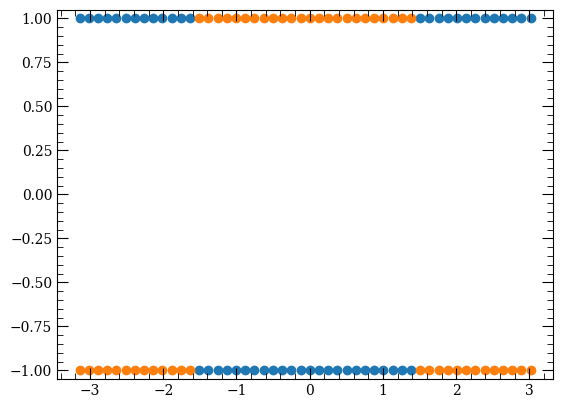

In [100]:
plt.scatter(kx,Chernup)
plt.scatter(kx,Cherndown)
plt.ylim(-1.05,1.05)

In [101]:
ky = 0
m=-1
kx = np.linspace(-np.pi,np.pi,101)
kw = np.linspace(-np.pi,np.pi,101)
Eband = np.zeros((len(kx),len(kw),4))
Espin = np.zeros((len(kx),len(kw),2))
for i in np.arange(len(kx)):
    for j in np.arange(len(kw)):
        _,_,Eband[i][j],Espin[i][j] = getSpinState(m,kx[i],ky,np.pi/2,kw[j])

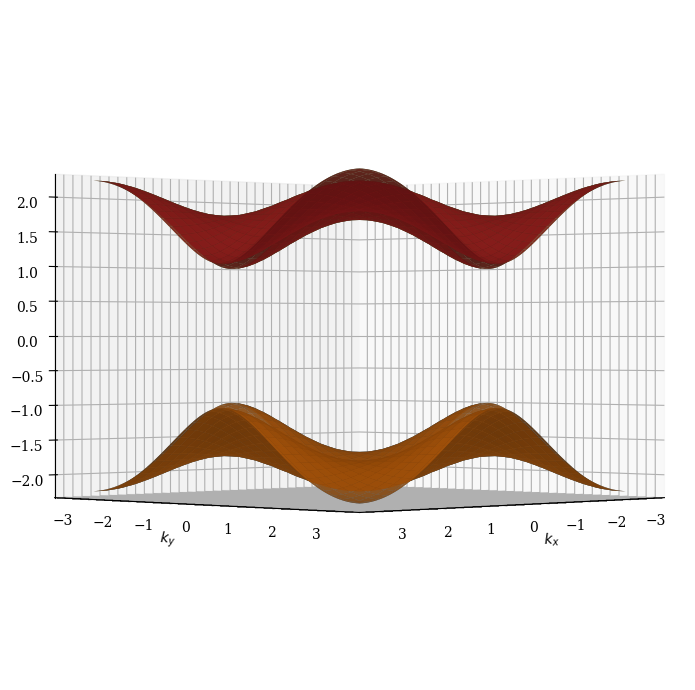

In [102]:
Qz,Qw = np.meshgrid(kx,kw,indexing='ij')
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 绘制两个能带
ax.plot_surface(Qz, Qw, Eband[:,:,0], alpha=0.8, edgecolor='none', label='Band 1')
ax.plot_surface(Qz, Qw, Eband[:,:,1], alpha=0.8, edgecolor='none', label='Band 2')
ax.plot_surface(Qz, Qw, Eband[:,:,2], alpha=0.8, edgecolor='none', label='Band 1')
ax.plot_surface(Qz, Qw, Eband[:,:,3], alpha=0.8, edgecolor='none', label='Band 2')
# 标签和视角
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$E(k)$')
ax.view_init(elev=0, azim=45)  # 调整视角

plt.tight_layout()
plt.show()

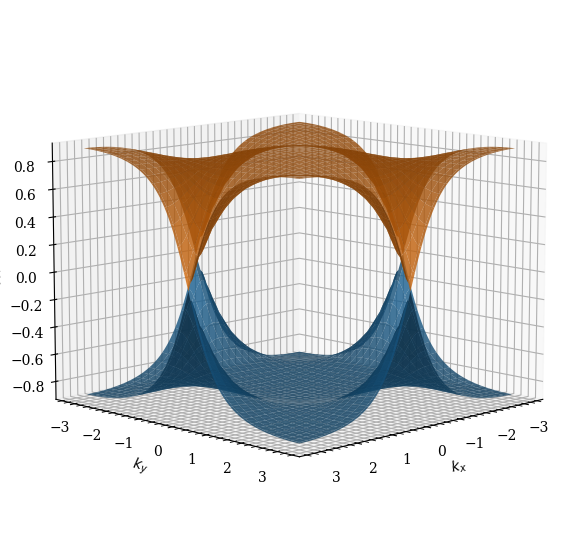

In [103]:

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 绘制两个能带
ax.plot_surface(Qz, Qw, Espin[:,:,0], alpha=0.8, edgecolor='none', label='Band 1')
ax.plot_surface(Qz, Qw, Espin[:,:,1], alpha=0.8, edgecolor='none', label='Band 2')

ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$E(k)$')
ax.view_init(elev=10, azim=45)  # 调整视角

plt.show()

In [16]:
def Ham(m,kx,ky,kz,t):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])

    gamma0 = np.kron(sigmaz,np.eye(2))
    gamma1 = np.kron(sigmay,sigmay)
    gamma2 = np.kron(sigmay,sigmax)
    gamma3 = np.kron(sigmay,sigmaz)
    gamma4 = np.kron(sigmax,np.eye(2))

    h0 =m+ np.cos(kx)+np.cos(ky)+np.cos(kz) + np.cos(t)
    h1 = np.sin(kx)
    h2 = np.sin(ky)
    h3 = np.sin(kz)
    h4 = np.sin(t)
    H = h0*gamma0 + h1*gamma1 + h2*gamma2 + h3*gamma3 + h4*gamma4
    return H

def Projection(m,kx,ky,kz,kw):
    H = Ham(m,kx,ky,kz,kw)
    _,eigvec = np.linalg.eigh(H)
    eigvec1 = eigvec[:,0].reshape(4,1)
    eigvec2 = eigvec[:,1].reshape(4,1)
    P = eigvec1@(eigvec1.T.conjugate()) + eigvec2@(eigvec2.T.conjugate())
    return P

def WCC(m,kx,ky,t):
    kz = np.linspace(-np.pi,np.pi,100)
    non_Abe_Berry = np.eye(4)
    for i in np.arange(len(kz)-1):
        #U = np.zeros((2,2),dtype=complex)
        #Hi = Ham(m,kx,ky,kz[i],t)
        #Ei,Vi = np.linalg.eigh(Hi)
        
        #Hi1 = Ham(m,kx,ky,kz[i+1],t)
        #Ei1,Vi1 = np.linalg.eigh(Hi1)
        #for m in np.arange(2):
            #for n in np.arange(2):
                #U[m,n] = (Vi[:,m].reshape(4,1).T.conjugate()@Vi1[:,n].reshape(4,1))[0][0]
        #V,E,W = np.linalg.svd(U)
        Pro = Projection(m,kx,ky,kz[i],t)
        non_Abe_Berry = Pro@non_Abe_Berry
    lam,V = np.linalg.eig(non_Abe_Berry)
    return non_Abe_Berry


In [51]:
m=-3
kx= np.pi/10
ky= np.pi/2
t=np.linspace(0,2*np.pi,100)
Zak = np.zeros((len(t),2),dtype=complex)
for i in np.arange(len(t)):
    lam = WCC(m,kx,ky,t[i])
    E,V = np.linalg.eig(lam)
    index = np.argsort(np.abs(E))
    Energy = 1j*np.log(E[index[2:4]])
    Zak[i] = Energy[np.argsort(Energy)]

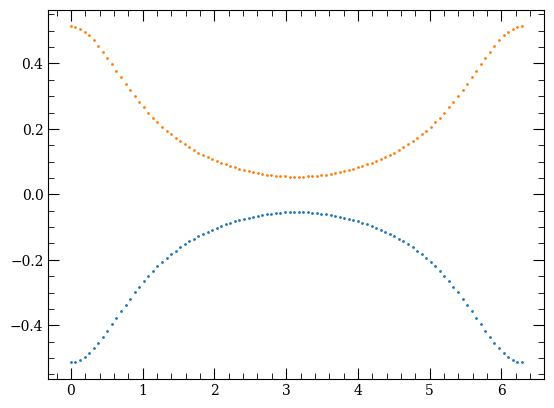

In [52]:
plt.scatter(t,Zak[:,0],s=1)
plt.scatter(t,Zak[:,1],s=1)
#plt.scatter(t,En[:,2])
#plt.scatter(t,En[:,3])


In [3]:
def Ham(m,kx,ky,kz,t):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])

    gamma0 = np.kron(sigmaz,np.eye(2))
    gamma1 = np.kron(sigmay,sigmay)
    gamma2 = np.kron(sigmay,sigmax)
    gamma3 = np.kron(sigmay,sigmaz)
    gamma4 = np.kron(sigmax,np.eye(2))

    h0 =m+ np.cos(kx)+np.cos(ky)+np.cos(kz) + np.cos(t)
    h1 = np.sin(kx)
    h2 = np.sin(ky)
    h3 = np.sin(kz)
    h4 = np.sin(t)
    H = h0*gamma0 + h1*gamma1 + h2*gamma2 + h3*gamma3 + h4*gamma4
    return H

def getBasis(m,kz):
    kx = np.linspace(-np.pi,np.pi,100)
    ky = np.linspace(-np.pi,np.pi,100)
    Basis = np.zeros((len(kx),len(ky),4,2),dtype=complex)
    Hin = Ham(m,np.pi/2,np.pi/2,np.pi/2,0)
    Ein,Vin = np.linalg.eigh(Hin)
    #Basis[0,0,:,0] = Vin[:,0]
    #Basis[0,0,:,1] = Vin[:,1]
    for i in range(len(kx)):
        for j in range(len(ky)):
            H = Ham(m, kx[i], ky[j], kz, 0)
            E, V = np.linalg.eigh(H)
            overlap = np.zeros(2)
            overlap[0] = np.abs(V[:,0].reshape(4,1).T.conjugate() @ Vin[:,0].reshape(4,1))[0][0]
            overlap[1] = np.abs(V[:,1].reshape(4,1).T.conjugate() @ Vin[:,0].reshape(4,1))[0][0]
            index = np.argsort(overlap)
            Basis[i,j,:,0] = V[:,index[1]]
            Basis[i,j,:,1] = V[:,index[0]]
    #for i in range(1, len(kx)):
        #H = Ham(m, kx[i], ky[0], kz, 0)
        #E, V = np.linalg.eigh(H)
        #overlap = np.zeros(2)
        #overlap[0] = np.abs(V[:,0].reshape(4,1).T.conjugate()@Basis[0,0,:,0].reshape(4,1))[0][0]
        #overlap[1] = np.abs(V[:,1].reshape(4,1).T.conjugate() @ Basis[0,0,:,0].reshape(4,1))[0][0]
        #index = np.argsort(overlap)
        #Basis[i,0,:,0] = V[:,index[1]]
        #Basis[i,0,:,1] = V[:,index[0]]

    # Step 3: 向 ky 方向传输整列
    #for j in range(1, len(ky)):
        #for i in range(len(kx)):
            #H = Ham(m, kx[i], ky[j], kz, 0)
            #E, V = np.linalg.eigh(H)
            #overlap = np.zeros(2)
            #overlap[0] = np.abs(V[:,0].reshape(4,1).T.conjugate() @ Basis[0,0,:,0].reshape(4,1))[0][0]
            #overlap[1] = np.abs(V[:,1].reshape(4,1).T.conjugate() @ Basis[0,0,:,0].reshape(4,1))[0][0]
            #index = np.argsort(overlap)
            #Basis[i,j,:,0] = V[:,index[1]]
            #Basis[i,j,:,1] = V[:,index[0]]
    return Basis





def Projection(m,kx,ky,kz,kw):
    H = Ham(m,kx,ky,kz,kw)
    _,eigvec = np.linalg.eigh(H)
    eigvec1 = eigvec[:,0].reshape(4,1)
    eigvec2 = eigvec[:,1].reshape(4,1)
    P = eigvec1@(eigvec1.T.conjugate()) + eigvec2@(eigvec2.T.conjugate())
    return P

def Willsonloop(m,kx,ky,kz,omega):
    #kx = np.linspace(-np.pi,np.pi,50)
    #ky = np.linspace(-np.pi,np.pi,50)
    T = 2*np.pi/omega
    t = np.linspace(0,T,100)
    kw = t/T*2*np.pi
    #kw = np.arange(-N+2,N,2)/N*np.pi
    #U = np.zeros((len(kx),len(ky),2,2),dtype=complex)
    #H = Ham(m,kx,ky,kz,0)
    #_,eigvec = np.linalg.eigh(H)
    #Pro = Evove(m,kx,ky,kz,omega)
    Pro = np.eye(4)
    for i in range(len(kw)):
        Pro = Projection(m,kx,ky,kz,kw[i])@Pro
    #for i in range(2):
        #for j in range(2):
            #U[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate())@Pro@(eigvec[:,j].reshape(4,1)))[0][0]
    return Pro #,U

def SpinWilson(U):
    H = -1j*logm(U)
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    Ux = np.trace(H@sigmax)
    Uy = np.trace(H@sigmay)
    Uz = np.trace(H@sigmaz)
    U0 = np.trace(H@np.eye(2))
    return Ux,Uy,Uz,U0 #spinx[0][0],spiny[0][0],spinz[0][0]

def Evove(m,kx,ky,kz,omega):
    T = 2*np.pi/omega
    t = np.linspace(0,T,500)
    dt = t[1]-t[0]
    U = np.eye(4)
    for i in range(len(t)):
        kw = t[i]/T*2*np.pi
        H = Ham(m,kx,ky,kz,kw)
        U = expm(-1j*H*dt) @ U
    return U

def Spintexutre(rho):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])

    gamma0 = np.kron(sigmaz,np.eye(2))
    gamma1 = np.kron(sigmay,sigmay)
    gamma2 = np.kron(sigmay,sigmax)
    gamma3 = np.kron(sigmay,sigmaz)
    gamma4 = np.kron(sigmax,np.eye(2))
    return np.trace(rho@gamma0),np.trace(rho@gamma1),np.trace(rho@gamma2),np.trace(rho@gamma3)

def nonAbeianBerryini(kx,ky,kz,m,dkx,dky,omega):
    H = Ham(m,kx,ky,kz,0)
    Uev = Evove(m,kx,ky,kz,omega)
    Hdkx = Ham(m,kx+dkx,ky, kz,0)
    Udkxev = Evove(m,kx+dkx,ky,kz,omega)
    Hdky = Ham(m,kx,ky+dky,kz,0)
    Udkyev = Evove(m,kx,ky+dky,kz,omega)
    Hdkxdky = Ham(m,kx+dkx,ky+dky,kz,0)
    Udkxdkyev = Evove(m,kx+dkx,ky+dky,kz,omega)
    _,eigvec = np.linalg.eigh(H)
    _,eigvecdkx = np.linalg.eigh(Hdkx)
    _,eigvecdky = np.linalg.eigh(Hdky)
    _,eigvecdkxdky = np.linalg.eigh(Hdkxdky)
    Ux =  np.zeros((2,2),dtype=complex)
    Uxf = np.zeros((2,2),dtype=complex)
    Uyx = np.zeros((2,2),dtype=complex)
    Uyxf = np.zeros((2,2),dtype=complex)
    Uy = np.zeros((2,2),dtype=complex)
    Uyf= np.zeros((2,2),dtype=complex)
    Uxy = np.zeros((2,2),dtype=complex)
    Uxyf = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            eigvecfi = Uev@(eigvec[:,i].reshape(4,1))
            eigvecdkxfi = Udkxev@(eigvecdkx[:,i].reshape(4,1))
            eigvecdkxfj = Udkxev@(eigvecdkx[:,j].reshape(4,1))
            eigvecdkyfi = Udkyev@(eigvecdky[:,i].reshape(4,1))
            eigvecdkyfj = Udkyev@(eigvecdky[:,j].reshape(4,1))
            eigvecdkxdkyfj = Udkxdkyev@(eigvecdkxdky[:,j].reshape(4,1))
            Ux[i][j]= (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkx[:,j].reshape(4,1)))[0][0]
            Uxf[i][j] = ((((eigvecfi.reshape(4,1)).T.conjugate()) @ (eigvecdkxfj.reshape(4,1)))[0][0])
            Uyx[i][j] = ((((eigvecdkx[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkxdky[:,j].reshape(4,1)))[0][0])
            Uyxf[i][j] =  ((((eigvecdkxfi.reshape(4,1)).T.conjugate()) @ (eigvecdkxdkyfj.reshape(4,1)))[0][0])
            Uxy[i][j] = ((((eigvecdky[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkxdky[:,j].reshape(4,1)))[0][0])
            Uxyf[i][j] = ((((eigvecdkyfi.reshape(4,1)).T.conjugate()) @ (eigvecdkxdkyfj.reshape(4,1)))[0][0])
            Uy[i][j] = ((((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdky[:,j].reshape(4,1)))[0][0])
            Uyf[i][j]= ((((eigvecfi.reshape(4,1)).T.conjugate()) @ (eigvecdkyfj.reshape(4,1)))[0][0])
    Uini =  np.linalg.det(Ux)*np.linalg.det(Uyx)*np.linalg.det(np.linalg.inv(Uxy))*np.linalg.det(np.linalg.inv(Uy))
    Uf =  np.linalg.det(Uxf)*np.linalg.det(Uyxf)*np.linalg.det(np.linalg.inv(Uxyf))*np.linalg.det(np.linalg.inv(Uyf))
    return np.log(Uini), np.log(Uf)




In [19]:
m = 3
qx = np.linspace(-np.pi,np.pi,100)
qy = np.linspace(-np.pi,np.pi,100)
qz = np.pi/2
omega = 0.1
sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
sigmaz = np.array([[1,0],[0,-1]])
#gamma0 = np.kron(sigmaz,np.eye(2))

Spinx = np.zeros((len(qx),len(qy)),dtype=complex)
Spiny = np.zeros((len(qx),len(qy)),dtype=complex)
Spinz = np.zeros((len(qx),len(qy)),dtype=complex)
Spin0 = np.zeros((len(qx),len(qy)),dtype=complex)
Basis = getBasis(m,qz)
Overlap = np.zeros((len(qx),len(qy),2,2))
#rho0 = np.eye(4)-gamma0
T = 2*np.pi/omega
Energy = np.zeros((len(qx),len(qy),2),dtype=complex)
for i in np.arange(len(qx)):
    for j in np.arange(len(qy)):
        Heff = np.zeros((2,2),dtype=complex)
        #H = Ham(m,qx[i],qy[j],qz,0)
        #_,eigV = np.linalg.eigh(H)
        #rho0 = eigV[:,0].reshape(4,1)@(eigV[:,0].reshape(4,1)).T.conjugate() + eigV[:,1].reshape(4,1)@(eigV[:,1].reshape(4,1)).T.conjugate()
        U = Willsonloop(m,qx[i],qy[j],qz,omega)#Evove(m,qx[i],qy[j],qz,omega)
        #U = Evove(m,qx[i],qy[j],qz,omega)
        #Pro = Basis[i,j,:,1].reshape(4,1)@(Basis[i,j,:,1].reshape(4,1)).T.conjugate()
        for m in range(2):
            for n in range(2):
                #Pro = Basis[i,j,:,m].reshape(4,1)@(Basis[i,j,:,n].reshape(4,1)).T.conjugate()
                #Overlap[i,j,m,n] = ((Basis[0,0,:,m].reshape(4,1)).T.conjugate()@Pro@Basis[0,0,:,n].reshape(4,1))[0][0]
                Heff[m,n] = (((Basis[i,j,:,m].reshape(4,1)).T.conjugate())@U@(Basis[i,j,:,n].reshape(4,1)))[0][0]
        E,V = np.linalg.eig(Heff)
        En = -1j*np.log(E)
        index = np.argsort(En.real)
        Energy[i][j] = En[index]
        Spinx[i][j] = (V[:,index[0]].reshape(2,1).T.conjugate()@sigmax@V[:,index[0]].reshape(2,1))[0][0]
        Spiny[i][j] = (V[:,index[0]].reshape(2,1).T.conjugate()@sigmay@V[:,index[0]].reshape(2,1))[0][0]
        Spinz[i][j] = (V[:,index[0]].reshape(2,1).T.conjugate()@sigmaz@V[:,index[0]].reshape(2,1))[0][0]
        Spin0[i][j] = (V[:,index[0]].reshape(2,1).T.conjugate()@np.eye(2)@V[:,index[0]].reshape(2,1))[0][0]
        #rho = U@rho0@U.T.conjugate()
        #Spin0[i][j],Spin1[i][j],Spin2[i][j],Spin3[i][j] = Spintexutre(rho0)
        #Heff = 1j*logm(U)/T
        #En,eigV = np.linalg.eig(U)
        #Energy[i][j] = 1j*np.log(En)/T
        #indexE = np.argsort(Energy[i][j])
        #rho = eigV[:,indexE[0]].reshape(4,1)@(eigV[:,indexE[0]].reshape(4,1)).T.conjugate() + eigV[:,indexE[1]].reshape(4,1)@(eigV[:,indexE[1]].reshape(4,1)).T.conjugate()
        #Spinx[i][j],Spiny[i][j],Spinz[i][j],Spin0[i][j] = SpinWilson(Heff)#Spintexutre(rho)
        

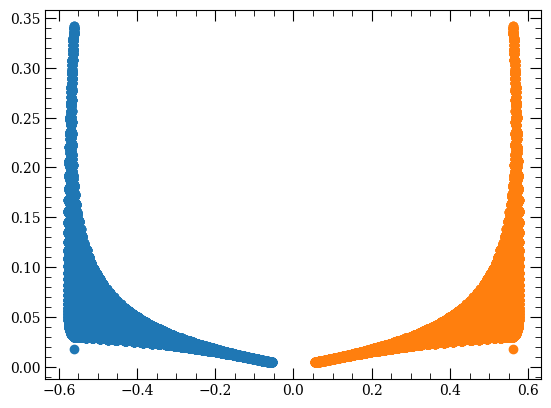

In [11]:
plt.scatter(Energy[:,:,0].real,Energy[:,:,0].imag)
plt.scatter(Energy[:,:,1].real,Energy[:,:,1].imag)

In [1]:
QX,QY = np.meshgrid(qx,qy,indexing='ij')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制能带曲面
sc = ax.plot_surface(QX, QY, Energy[:,:,0].real)
sc = ax.plot_surface(QX, QY, Energy[:,:,1].real)
# 设置标签
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
ax.set_zlabel('Energy E(k)')
ax.view_init(elev=10, azim=120)

NameError: name 'np' is not defined

d:\anaconda\lib\site-packages\matplotlib\contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
d:\anaconda\lib\site-packages\matplotlib\contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
d:\anaconda\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


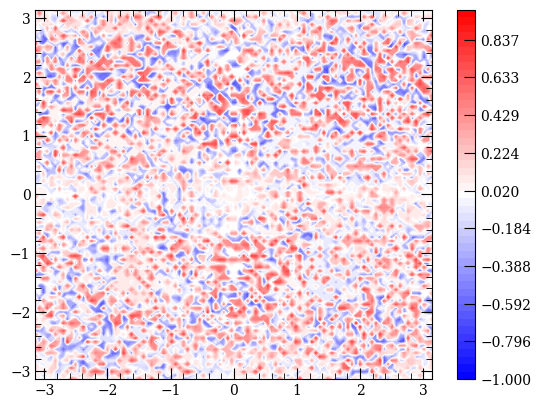

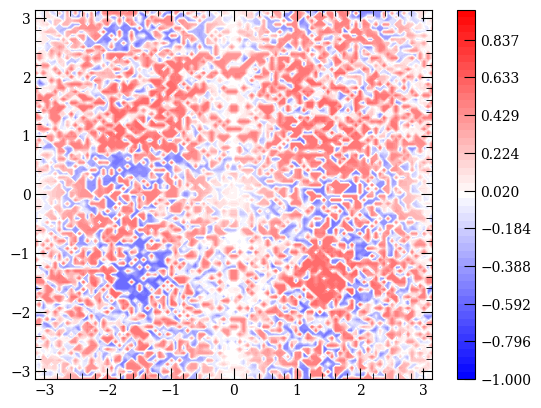

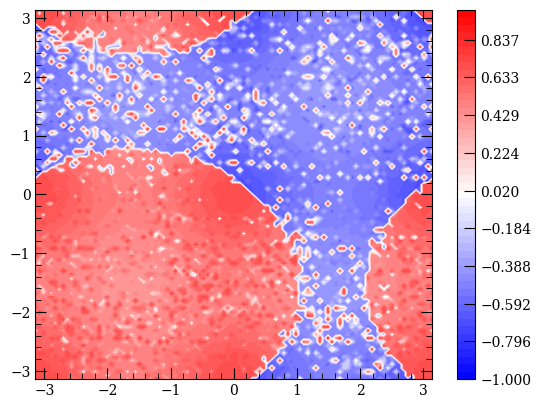

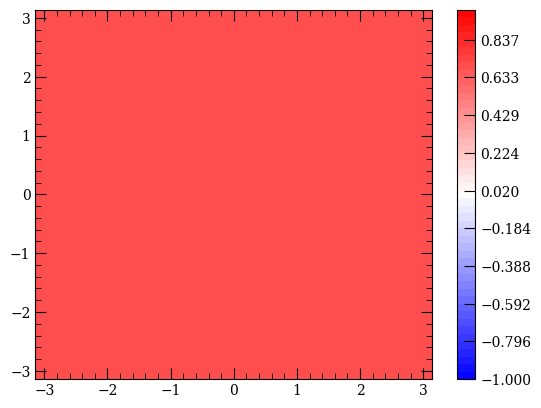

<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

In [20]:
Qx,Qy = np.meshgrid(qx,qy,indexing='ij')
plt.figure
plt.contourf(Qx,Qy,Spinx/np.sqrt(Spin0**2+Spinx**2+Spiny**2+Spinz**2),cmap='bwr',levels = np.linspace(-1,1,50))
plt.colorbar()
plt.show()
plt.figure
plt.contourf(Qx,Qy,Spiny/np.sqrt(Spin0**2+Spinx**2+Spiny**2+Spinz**2),cmap='bwr',levels = np.linspace(-1,1,50))
plt.colorbar()
plt.show()
plt.figure
plt.contourf(Qx,Qy,Spinz/np.sqrt(Spin0**2+Spinx**2+Spiny**2+Spinz**2),cmap='bwr',levels = np.linspace(-1,1,50))
plt.colorbar()
plt.show()
plt.figure
plt.contourf(Qx,Qy,Spin0/np.sqrt(Spin0**2+Spinx**2+Spiny**2+Spinz**2),cmap='bwr',levels = np.linspace(-1,1,50))
plt.colorbar()
plt.show()
plt.figure

In [27]:
Spinx

array([[ 2.29647146e-16,  1.97150525e-01,  1.95080364e-01, ...,
         1.95080364e-01,  1.97150525e-01,  1.95066700e-01],
       [ 1.97150525e-01,  1.96406832e-01,  1.94445661e-01, ...,
         1.94445661e-01,  1.96406832e-01,  1.97150525e-01],
       [ 1.95080364e-01,  1.94445661e-01,  8.24702279e-01, ...,
         1.92763264e-01,  1.94445661e-01,  1.95080364e-01],
       ...,
       [ 1.95080364e-01,  1.94445661e-01,  1.92763264e-01, ...,
         1.92763264e-01,  1.94445661e-01,  1.95080364e-01],
       [ 1.97150525e-01,  1.96406832e-01,  1.94445661e-01, ...,
         1.94445661e-01,  1.45143229e-01,  1.97150525e-01],
       [ 8.40579281e-01,  1.97150525e-01,  1.95080364e-01, ...,
         1.95080364e-01,  1.97150525e-01, -8.49116255e-01]])

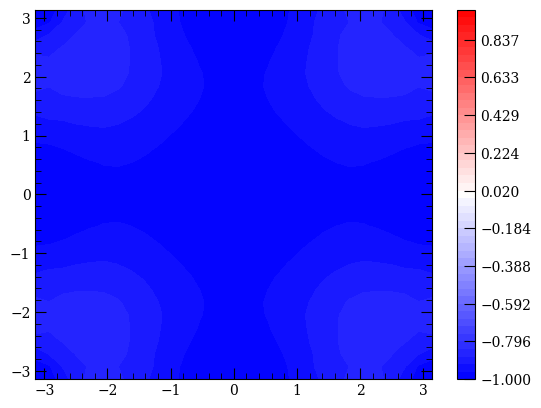

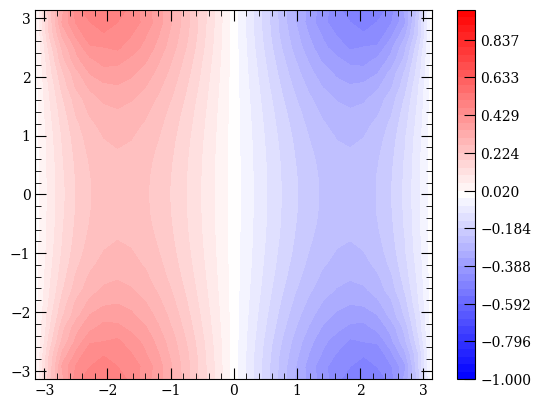

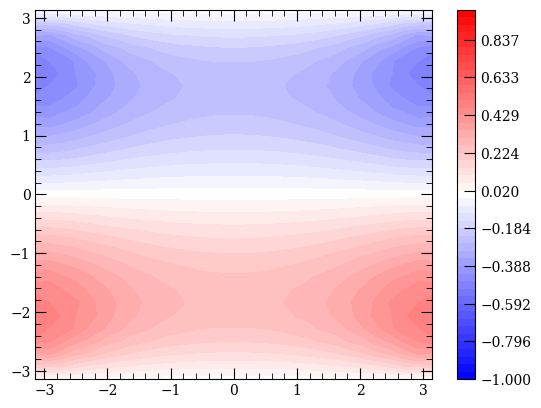

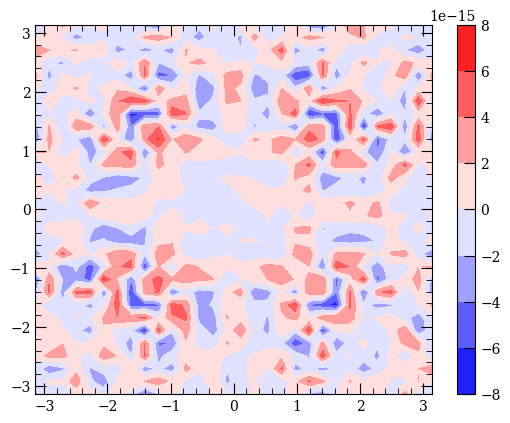

<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

In [ ]:
Qx,Qy = np.meshgrid(qx,qy,indexing='ij')
plt.figure
plt.contourf(Qx,Qy,Spin0/np.sqrt(Spin0**2+Spin1**2+Spin2**2),cmap='bwr',levels = np.linspace(-1,1,50))
plt.colorbar()
plt.show()
plt.figure
plt.contourf(Qx,Qy,Spin1/np.sqrt(Spin0**2+Spin1**2+Spin2**2),cmap='bwr',levels = np.linspace(-1,1,50))
plt.colorbar()
plt.show()
plt.figure
plt.contourf(Qx,Qy,Spin2/np.sqrt(Spin0**2+Spin1**2+Spin2**2),cmap='bwr',levels = np.linspace(-1,1,50))
plt.colorbar()
plt.show()
plt.figure
plt.contourf(Qx,Qy,Spin3,cmap='bwr')
plt.colorbar()
plt.show()
plt.figure

In [ ]:
m=1
qx =0 
qy = 0
omega=0.1
qz = np.linspace(-np.pi,np.pi,100)
Energy = np.zeros((len(qz),2),dtype=complex)
for i in range(len(qz)):
    #H = Ham(m,qx,qy,qz[i],0)
    #_,eigV = np.linalg.eigh(H)
    U = Evove(m,qx,qy,qz[i],omega)
    for m in range(2):
        for n in range(2):
            Uini = ((eigV[:,m].reshape(4,1)).T.conjugate())@U@(eigV[:,n].reshape(4,1))
            En,_ = np.linalg.eig(Uini)
            Energy[i] = 1j*np.log(En)

C:\Users\lin\AppData\Local\Temp\ipykernel_26016\1926898949.py:15: RuntimeWarning: divide by zero encountered in log
  Energy[i] = 1j*np.log(En)
C:\Users\lin\AppData\Local\Temp\ipykernel_26016\1926898949.py:15: RuntimeWarning: invalid value encountered in multiply
  Energy[i] = 1j*np.log(En)


d:\anaconda\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\anaconda\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


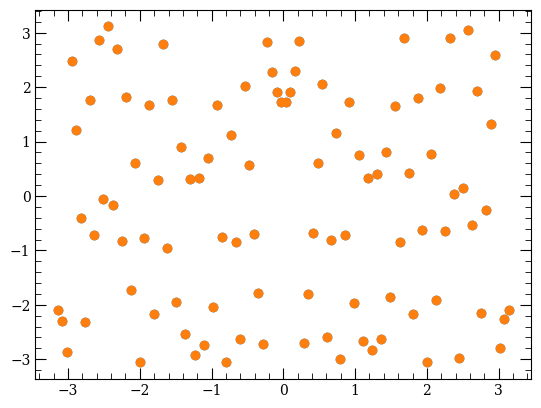

In [ ]:
plt.scatter(qz,Energy[:,0])
plt.scatter(qz,Energy[:,1])

In [ ]:
m = 1
Nkx = 20
Nky = 20
qx = np.arange(-Nkx,Nkx,2)/Nky*np.pi
dqx = qx[1]-qx[0]
qy = np.arange(-Nky,Nky,2)/Nkx*np.pi 
dqy = qy[1]-qy[0]
omega = 0.1
kz = np.pi/4
Uini = np.zeros((len(qx),len(qy),2,2),dtype=complex)
#Uf = np.zeros(((len(qx)),len(qy)),dtype=complex)
for i in range(len(qx)):
    for j in range(len(qy)):
        H = Ham(m,qx[i],qy[i],kz,0)
        _,eigV = np.linalg.eigh(H)
        U = Evove(m,qx[i],qy[i],kz,omega)
        for m in range(2):
            for n in range(2):
                Uini[i][j][m][n] = ((eigV[:,m].reshape(4,1)).T.conjugate())@U@(eigV[:,n].reshape(4,1))
        #Uini[i,j], Uf[i,j] = nonAbeianBerryini(qx[i],qy[j],kz,m,dqx,dqy,omega)


In [ ]:
Berryphase = np.zeros((len(qx),len(qy)),dtype=complex)
Energy = np.zeros((len(qx),len(qy),2),dtype=complex)
for i in range(len(qx)):
    for j in range(len(qy)):
        Berryphase[i][j] = np.linalg.det(Uini[i][j])
        En,_ = np.linalg.eig(Uini[i][j])
        Energy[i][j] = 1j*np.log(En)


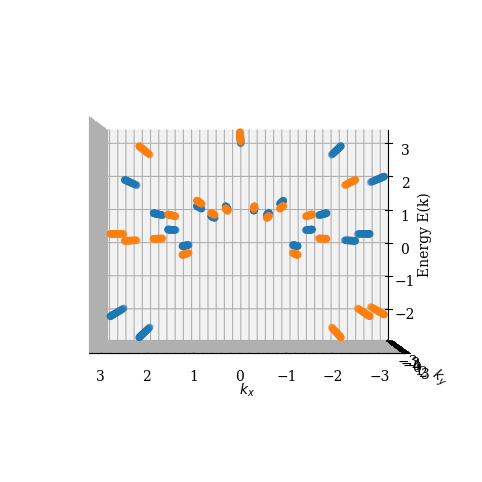

In [ ]:
QX,QY = np.meshgrid(qx,qy,indexing='ij')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制能带曲面
sc = ax.scatter(QX.flatten(), QY.flatten(), (Energy[:,:,0].real).flatten())
sc = ax.scatter(QX.flatten(), QY.flatten(), (Energy[:,:,1].real).flatten())
# 设置标签
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
ax.set_zlabel('Energy E(k)')
ax.view_init(elev=0, azim=90)

d:\anaconda\lib\site-packages\matplotlib\contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
d:\anaconda\lib\site-packages\matplotlib\contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
d:\anaconda\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


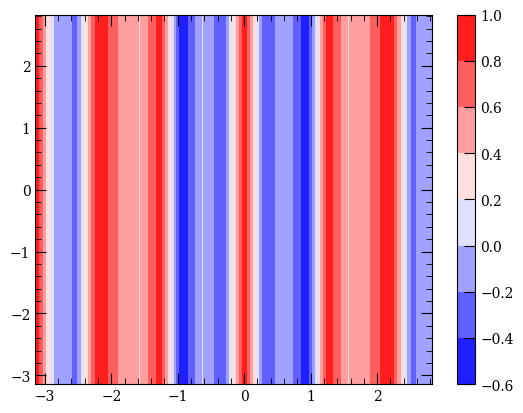

In [ ]:
QX,QY = np.meshgrid(qx,qy,indexing='ij')
plt.figure
plt.contourf(QX,QY,Berryphase,cmap='bwr')
plt.colorbar()
plt.show()

In [ ]:
np.sum(Berryphase*dqx*dqy)/2/np.pi

(1.6203367406835854-2.5080028467185063j)

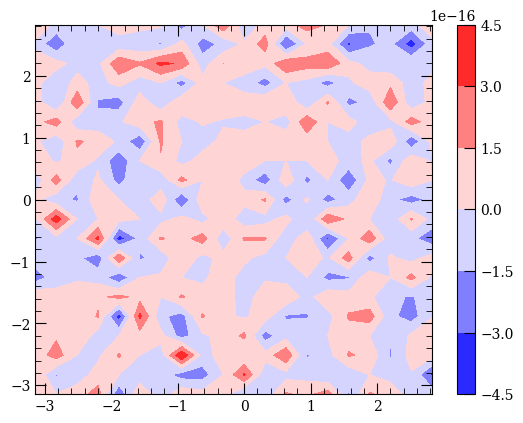

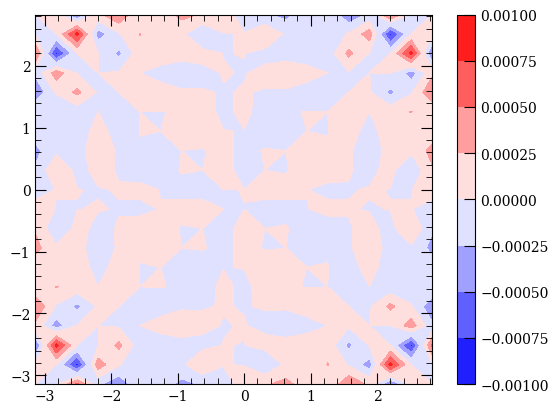

In [ ]:
QX,QY = np.meshgrid(qx,qy,indexing='ij')
plt.figure
plt.contourf(QX,QY,Uini.imag,cmap='bwr')
plt.colorbar()
plt.show()

plt.figure
plt.contourf(QX,QY,Uf.imag,cmap='bwr')
plt.colorbar()
plt.show()

In [ ]:
np.sum(Uini.imag)/2/np.pi

1.7125422546674178e-17

In [ ]:
np.sum(Uf.imag)/2/np.pi

6.803888405496227e-17